```{index} single: application; shortest path
```
```{index} networkx
```
```{index} network optimization
```
```{index} pandas dataframe
```

# Extra material: Shortest path problem in real life


In [1]:
import subprocess
import sys


class ColabInstaller:
    def __init__(self):
        reqs = subprocess.check_output([sys.executable, "-m", "pip", "freeze"])
        self.installed_packages = [r.decode().split("==")[0] for r in reqs.split()]

    def on_colab(self):
        return "google.colab" in sys.modules

    def install(self, package):
        if self.on_colab():
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "-q", package]
            )
            self.installed_packages.append(package)

    def upgrade(self, package):
        if self.on_colab():
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "-q", "--upgrade", package]
            )


if "google.colab" in sys.modules:
    colab = ColabInstaller()
    colab.upgrade("numpy")
    colab.upgrade("matplotlib")
    colab.install("geopandas")
    colab.install("geopy")
    colab.install("osmnx")
    colab.install("osmnet")
    colab.install("pandana")
    colab.upgrade("geopy")

# Introduction

Google brought with [maps]( https://www.google.com/maps) the world to our screens, including accurate geocoding and routing for several modalities. For the most, the usage of [maps]( https://www.google.com/maps) is interactive. As data and analytics professionals we often need a programmatically support for the services that [maps]( https://www.google.com/maps) offer us, preferably free. It also offers a plethora of [development support](https://developers.google.com/), but unfortunately most is paid. That is even more so for [maps]( https://developers.google.com/maps/documentation).

## Some background information and history 
[Geoff Boeing]( https://geoffboeing.com/about/) is a true leader in demystifying urban data analytics, with a strong emphasis on street networks. His [peer reviewed publications]( https://geoffboeing.com/publications/) are open and accompanied by usable demonstrations using his own [OSMnx]( https://geoffboeing.com/2018/03/osmnx-features-roundup/) package.
Professor [Peter Sanders]( https://algo2.iti.kit.edu/english/sanders.php), see also his [Wikipedia]( https://en.wikipedia.org/wiki/Peter_Sanders_(computer_scientist)) page, has moved his interests to other areas but his [route planning]( http://algo2.iti.kit.edu/routeplanning.php) project shaped the world of truly scalable road routing algorithms. 
From his alumni I distinguish two persons:
 * [Dominik Schultes](http://algo2.iti.kit.edu/schultes/) who won the [DIMACS challenge on shortest paths]( http://www.diag.uniroma1.it//challenge9/data/tiger/) and made it to the [Scientific American top 50]( https://www.scientificamerican.com/article/sciam-50-the-fastest-way/). Before Dominik’s research scalable shortest paths on large national road networks where heuristics, now they are exact and can be computed at world scale. 
 * [Dennis Luxen]( http://algo2.iti.kit.edu/english/luxen.php) for creating https://github.com/Project-OSRM/osrm-backend which offers a free, scalable, implementation of [contraction hierarchies]( https://en.wikipedia.org/wiki/Contraction_hierarchies).
 
Finally, I mention [Fletcher Foti]( https://fletcherfoti.weebly.com/) who gave us [pandana]( http://udst.github.io/pandana/).
 


## Geocoding and map visualization

The world is mapped with the [geographic coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system) but we have difficulties remembering [latitudes]( https://en.wikipedia.org/wiki/Latitude) and [longitudes]( https://en.wikipedia.org/wiki/Longitude). We learn and remember the world better from addresses. 

In [1]:
import osmnx as ox
import osmnet as osm
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import geopy
import folium
import networkx as nx
from IPython.display import display

In [2]:
def FreeLocator():
    return geopy.Photon(user_agent="myGeocoder")


def locate_geopy(description):
    location = FreeLocator().geocode(description)
    if location is not None:
        return location.latitude, location.longitude
    return None, None


pd.options.display.float_format = "{:.6f}".format

data = {
    "address": [
        "Centraal Station",
        "VU Hoofdgebouw",
        "Amsterdam Business School",
        "University of Amsterdam",
        "Johan Cruijff ArenA",
        "Ziggo Dome",
    ],
    "color": ["blue", "black", "orange", "green", "red", "purple"],
}

df = pd.DataFrame(data)
df["city"] = "Amsterdam"
df["country"] = "NL"

locations = [
    locate_geopy(",".join(row[["address", "city", "country"]]))
    for _, row in df.iterrows()
]
df["lat"] = [loc[0] for loc in locations]
df["lon"] = [loc[1] for loc in locations]
display(df)

Amsterdam = FreeLocator().geocode("Amsterdam, NL")

Map = folium.Map(location=(Amsterdam.latitude, Amsterdam.longitude), zoom_start=13)

for _, row in df.iterrows():
    folium.Marker(
        (row.lat, row.lon), icon=folium.Icon(color=row.color), tooltip=row.address
    ).add_to(Map)
Map

,address,color,city,country,lat,lon
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.312896,4.942167
5,Ziggo Dome,purple,Amsterdam,NL,52.313793,4.938057


In [3]:
ox.settings.log_console = True
ox.settings.use_cache = True

In [4]:
%%time 
G_walk = ox.graph_from_place('Amsterdam, NL', network_type='walk')

CPU times: user 19.9 s, sys: 389 ms, total: 20.2 s
Wall time: 20.2 s


In [5]:
print(G_walk.number_of_nodes(), G_walk.number_of_edges())

43178 121686


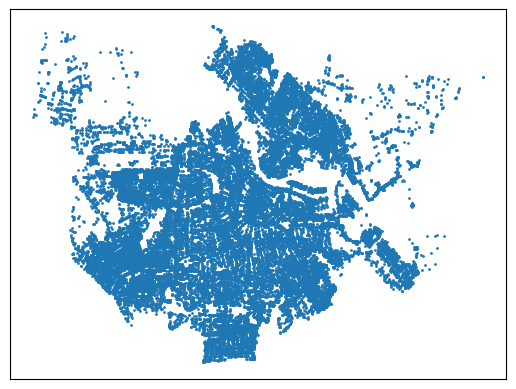

In [6]:
node_positions = {
    node: (data["x"], data["y"]) for node, data in G_walk.nodes(data=True)
}
nx.draw_networkx_nodes(G_walk, pos=node_positions, node_size=1)

In [7]:
df["osmnx"] = ox.distance.nearest_nodes(G_walk, df.lon, df.lat)
df

,address,color,city,country,lat,lon,osmnx
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581,5629072001
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901,294648098
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718,46356661
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804,8121695895
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.312896,4.942167,10967577086
5,Ziggo Dome,purple,Amsterdam,NL,52.313793,4.938057,10967577086


In [15]:
%time route = nx.shortest_path(G_walk,df.iloc[0].osmnx,df.iloc[1].osmnx,weight='length')
print(route)

CPU times: user 68.4 ms, sys: 2.87 ms, total: 71.3 ms
Wall time: 70 ms
[5629072001, 5629072000, 5629071975, 4239313191, 4239313081, 4239313075, 4239312638, 4239312162, 6358902057, 3175792586, 3175727845, 10633464529, 10633464528, 9959600348, 9959600349, 9959600284, 9971788077, 9971788076, 9817686663, 9817686662, 10208267268, 6841663011, 6841663007, 6841654478, 8608994367, 8072948169, 6841636869, 6841636868, 6841645041, 6841680457, 6841680467, 6841680468, 6841680481, 8036446640, 8036446607, 8036446617, 8036446621, 8036446623, 8036446626, 9140788997, 8036446635, 8036446637, 3412535141, 3416675281, 3416675272, 3416675263, 3416675257, 6949114049, 6949114048, 10823781800, 6949114037, 6949114047, 6949114046, 5792613757, 46332984, 7191491361, 8852212652, 46331976, 46330373, 1976839698, 7191576329, 7191576325, 5805311952, 10073385072, 5805311930, 5805311950, 46321108, 46318613, 5805314256, 5805314261, 6653510565, 6653544388, 6653544407, 6653544420, 1976839614, 46308487, 46307158, 46305753, 463

In [20]:
route_map = ox.plot_route_folium(G_walk, route)
display(route_map)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_90780/3687851812.py:1: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(G_walk, route)


# Dijkstra on steroids for road networks

In [31]:
nodes = pd.DataFrame.from_dict(dict(G_walk.nodes(data=True)), orient="index")
edges = nx.to_pandas_edgelist(G_walk)

In [ ]:
%%time
import pandana
network = pandana.Network(nodes['x'], nodes['y'], edges['source'], edges['target'], edges[['length']],twoway=True)

CPU times: user 2.75 s, sys: 44.6 ms, total: 2.8 s
Wall time: 2.98 s


In [ ]:
network.nodes_df.head()

,x,y
6316199,4.888396,52.370173
25596455,4.923563,52.364840
25596477,4.906097,52.367000
25645989,4.925075,52.365727
25658579,4.930438,52.364544


In [ ]:
network.edges_df.head()

,from,to,length
0,6316199,46379627,42.497000
1,6316199,46389218,225.577000
2,6316199,391355271,62.907000
3,25596455,8383889398,1.791000
4,25596455,46356773,41.700000


In [ ]:
df["pandana"] = network.get_node_ids(df.lon, df.lat).values
df

,address,color,city,country,lat,lon,osmnx,pandana
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581,5629072001,5629071974
1,Amsterdam Business School,black,Amsterdam,NL,52.365107,4.911718,46356661,46356661
2,Artis,green,Amsterdam,NL,-30.401207,-56.481521,1768194163,1768194163
3,Arena,red,Amsterdam,NL,52.315990,4.942931,4622542635,2928936658
4,Ziggo Dome,purple,Amsterdam,NL,52.313629,4.938207,1925143759,4622542635


In [ ]:
%time path_pandana = network.shortest_path(df.iloc[2].pandana, df.iloc[3].pandana)

CPU times: user 10.6 ms, sys: 5.56 ms, total: 16.1 ms
Wall time: 15.3 ms


In [ ]:
%time path_nx = nx.shortest_path(G_walk,df.iloc[2].osmnx,df.iloc[3].osmnx,weight='length')

CPU times: user 268 ms, sys: 17.9 ms, total: 286 ms
Wall time: 291 ms


In [ ]:
A = set(path_pandana)
B = set(path_nx)
(A | B) - (A & B)

{46232158,
 46237572,
 46240581,
 46241169,
 46241205,
 46242937,
 46242940,
 46245940,
 46247806,
 46255649,
 46260704,
 46264996,
 46265577,
 46265994,
 46266419,
 46267226,
 46267229,
 46274385,
 46274670,
 46275359,
 46275510,
 46278192,
 46278488,
 46280478,
 46280842,
 46281091,
 46281209,
 46281430,
 46281524,
 46281920,
 46283239,
 46283971,
 46284393,
 46284949,
 46285251,
 46285451,
 46288061,
 46291556,
 254477712,
 262890789,
 497304704,
 497304720,
 878805275,
 878806012,
 878806213,
 878808875,
 1101933078,
 1259406528,
 1545015322,
 1548111106,
 1688255243,
 1725810217,
 1725960722,
 1925156931,
 1925156934,
 2801224787,
 2928936658,
 3132312675,
 4382189126,
 4382189139,
 4538188789,
 4622542635,
 4684390284,
 4684390320,
 5133014954,
 5323513026,
 5394045965,
 5394053135,
 5438332847,
 5438332850,
 6614935661,
 6653983649,
 6654004829,
 6879899205,
 6879899216,
 6892142909,
 6892143052,
 6958932853,
 6958932854,
 6958932858,
 7124847108,
 7434739098,
 7434739102,
 8492

In [ ]:
origs = [o for o in df.pandana for d in df.pandana]
dests = [d for o in df.pandana for d in df.pandana]
%time distances = network.shortest_path_lengths(origs, dests)

CPU times: user 14.1 ms, sys: 3.95 ms, total: 18 ms
Wall time: 16.7 ms


In [ ]:
import numpy as np

n = len(df)
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame(
    np.array(list(distances)).reshape(n, n), index=df.address, columns=df.address
)

address,Centraal Station,Amsterdam Business School,Artis,Arena,Ziggo Dome
address,,,,,
Centraal Station,0.00,2218.20,11501.29,6274.28,6084.35
Amsterdam Business School,2218.20,0.00,11825.68,4130.58,4537.02
Artis,11501.29,11825.68,0.00,14651.95,13954.61
Arena,6274.28,4130.58,14651.95,0.00,4127.14
Ziggo Dome,6084.35,4537.02,13954.61,4127.14,0.00


In [ ]:
np.random.seed(2023)
n = 500
sample = np.random.choice(
    np.array(network.nodes_df.index.values.tolist()), n, replace=False
)
origs = [o for o in sample for d in sample]
dests = [d for o in sample for d in sample]

In [ ]:
%time distances = network.shortest_path_lengths(origs, dests)
%time table = pd.DataFrame(np.array(list(distances)).reshape(n,n),index=sample,columns=sample)

CPU times: user 5.23 s, sys: 65.9 ms, total: 5.3 s
Wall time: 5.33 s
CPU times: user 21.1 ms, sys: 297 µs, total: 21.4 ms
Wall time: 21.5 ms


In [ ]:
departure = table.max(axis=1).idxmax()
arrival = table.loc[departure].idxmax()
%time path_pandana = network.shortest_path(departure, arrival)
%time path_nx = nx.shortest_path(G_walk,departure,arrival,weight='length')
A = set(path_pandana)
B = set(path_nx)
(A | B) - (A & B)

CPU times: user 4.6 ms, sys: 3.47 ms, total: 8.07 ms
Wall time: 7.24 ms
CPU times: user 594 ms, sys: 17.1 ms, total: 611 ms
Wall time: 617 ms


set()

In [ ]:
%time paths = network.shortest_paths(origs,dests)

CPU times: user 12.9 s, sys: 549 ms, total: 13.5 s
Wall time: 13.5 s


In [ ]:
sum(map(len, paths))

35377572

In [ ]:
for u, v in zip(paths[1][:-1], paths[1][1:]):
    print(G_walk.get_edge_data(u, v)[0].get("name", ""))








Oostoever

Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat



Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Jan Evertsenstraat
Orteliuskade
Orteliuskade
Orteliuskade
Van Middellandtstraat
Orteliusstraat
Postjesweg
Van Spilbergenstraat
Postjesweg




Hoofdweg
Hoofdweg
Hoofdweg
Hoofdweg
Hoofdweg
Hoofdweg
Surinameplein
Surinameplein
Surinamestraat
Surinamestraat
Surinamestraat
['Surinamestraat', 'Overtoom']
Overtoom

Overtoom
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg


Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Amstelveenseweg
Laan der Hesperiden



Stadionplein
Laan der Hesperiden
Laan der Hesperiden

In [ ]:
route_map = ox.plot_route_folium(G_walk, paths[1], color="red", map=Map)
display(route_map)